# Convert PDFs to text

In [37]:
import shutil
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
# import numpy as np
# import pytesseract
import regex as re
import skimage
# from IPython.display import display
# from ipywidgets import interact
# from PIL import Image, ImageDraw, ImageOps
# from skimage import data, feature, measure, morphology, restoration
from skimage import color, filters, io, morphology, util

In [3]:
DATA_DIR = Path('..') / 'data'
IMAGE_DIR = DATA_DIR / 'images'
PDF_DIR = DATA_DIR / 'pdfs'
TEXT_DIR = DATA_DIR / 'text'
TEMP_DIR = DATA_DIR / 'temp'

## Convert PDFs to images

### Get old PDF names

In [4]:
old_names = !ls $PDF_DIR
old_names

['Barneby_1991_Sensitivae_Censitae.pdf',
 'Barneby_1998_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_III.pdf',
 'Barneby_and_Grimes_1996_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_I.pdf',
 'Barneby_and_Grimes_1997_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_II.pdf',
 'Ebinger_Seigler_Clarke_2000_Taxonomic_Revision_of_South_American_species_of_the_genus_Acacia_subgenus_Acacia_Fabaceae_Mimosoideae.pdf',
 'flora_australia_11a_mimosaceae_acacia_1_2.pdf',
 'flora_australia_11b_mimosaceae_acacia_2.pdf',
 'flora_australia_12_mimosaceae_exacacia_caesalpiniaceae.pdf']

### Rename bad file names

Remove characters that cause command line utilities problems. Remove spaces, commas, parentheses, etc.

In [5]:
new_names = []
for old_name in old_names:
    path = Path(old_name)
    stem = path.stem
    stem = re.sub(r'[^\w.]', '_', stem)
    stem = re.sub(r'__+', '_', stem)
    stem = re.sub(r'_+$', '', stem)

    new_name = path.with_stem(stem)
    new_names.append(new_name)

    if new_name != old_name:
        old = PDF_DIR / old_name
        new = PDF_DIR / new_name
        shutil.move(old, new)

new_names

[PosixPath('Barneby_1991_Sensitivae_Censitae.pdf'),
 PosixPath('Barneby_1998_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_III.pdf'),
 PosixPath('Barneby_and_Grimes_1996_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_I.pdf'),
 PosixPath('Barneby_and_Grimes_1997_Silk_Tree_Guanacaste_Monkey_s_Earring_Part_II.pdf'),
 PosixPath('Ebinger_Seigler_Clarke_2000_Taxonomic_Revision_of_South_American_species_of_the_genus_Acacia_subgenus_Acacia_Fabaceae_Mimosoideae.pdf'),
 PosixPath('flora_australia_11a_mimosaceae_acacia_1_2.pdf'),
 PosixPath('flora_australia_11b_mimosaceae_acacia_2.pdf'),
 PosixPath('flora_australia_12_mimosaceae_exacacia_caesalpiniaceae.pdf')]

### Convert all PDF pages to an image

The poppler utils has a nice utility for converting PDF pages to images (`pdftocairo`), one image per page.

`sudo apt install poppler-utils`

In [6]:
def pdf2images(name):
    print(name)

    src = PDF_DIR / name

    stem = Path(name).stem
    dir_ = IMAGE_DIR / stem
    dst = dir_ / stem

    !mkdir - p $dir_
    !pdftocairo - jpeg $src $dst

In [7]:
# for name in new_names:
#     pdf2images(name)

In [8]:
matplotlib.rc('axes', titlesize=36)


def show_2_up(image1, image2):
    fig, ax = plt.subplots(
        nrows=1, ncols=2, figsize=(24, 20), sharex=True, sharey=True
    )
    ax[0].imshow(image1)
    ax[0].axis('off')
    ax[0].set_title('Original')

    ax[1].imshow(image2, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('Processed')

    fig.tight_layout()

    plt.show()

## Segment pages into columns and other parts

Many pages have multiple columns which will confuse the OCR engines.

In [38]:
SIGMA = 11

WINDOW_SIZE = 11
K = 0.032

WEIGHT = 0.1
CHANNEL_AXIS = -1

In [39]:
def pipeline():
    for name in new_names:
        stem = Path(name).stem
        dir_ = IMAGE_DIR / stem
        for page in sorted(dir_.glob('*.jpg')):
            print(page)

            image = io.imread(page)
            image = skimage.img_as_float(image)
            gray = color.rgb2gray(image)

            # denoised = restoration.denoise_tv_chambolle(
            #     image, weight=WEIGHT, channel_axis=CHANNEL_AXIS
            # )

            blurred = filters.gaussian(gray, sigma=SIGMA)

            # threshold = filters.threshold_sauvola(blurred, window_size=WINDOW_SIZE, k=K)
            threshold = filters.threshold_otsu(blurred)
            binary = blurred > threshold

            inverted = util.invert(binary)

            # processed = binarize(blurred)

            hulls = morphology.convex_hull_object(inverted)
            print(hulls.shape)

            show_2_up(image, inverted)
            return

../data/images/Barneby_1991_Sensitivae_Censitae/Barneby_1991_Sensitivae_Censitae-014.jpg
(1921, 1361)


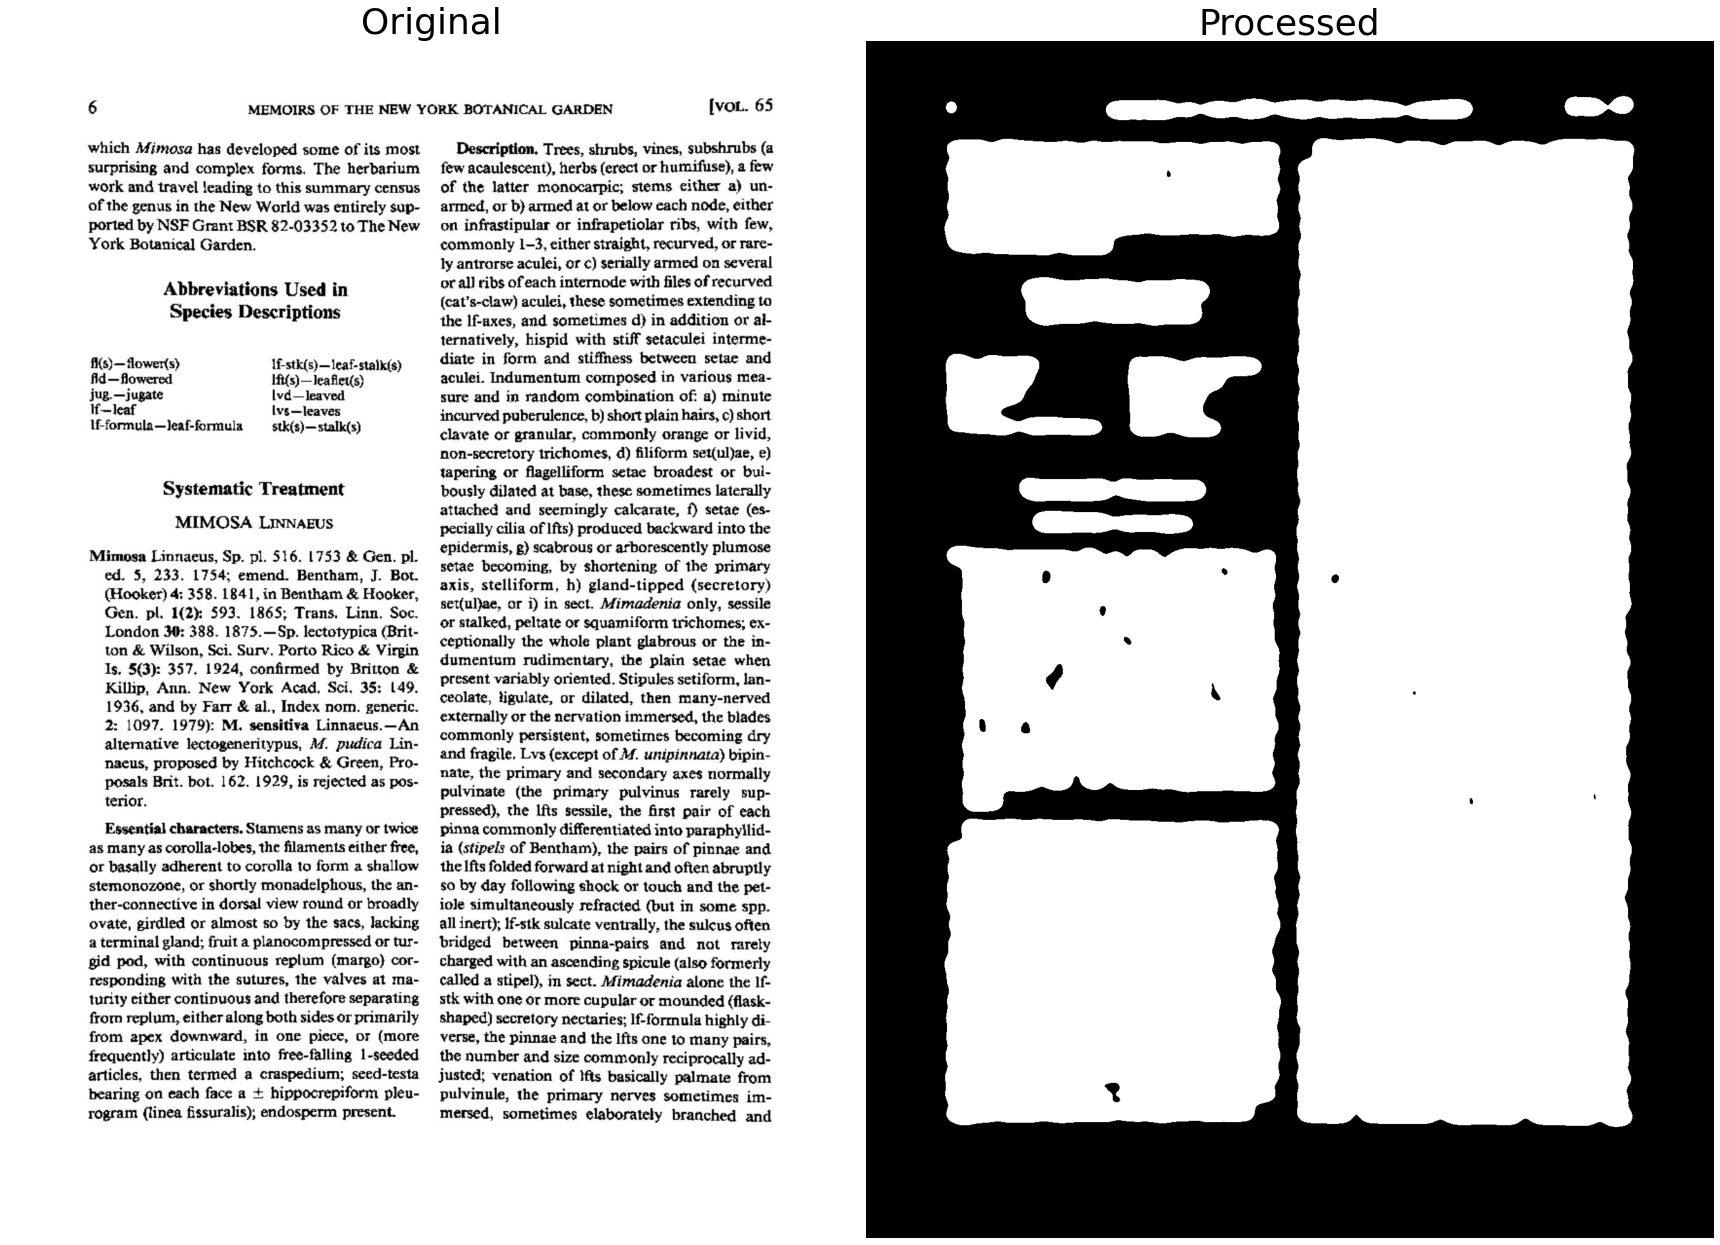

In [40]:
pipeline()